## Import Modules

In [258]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from PIL import Image
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

## Load the Dataset

In [259]:
# DATASET = 'affectnet'
DATASET = 'fer2013'
# DATASET = 'mma'
# DATASET = 'merged_dataset'

TRAIN_DIR = f"input/{DATASET}/train/"
TEST_DIR = f"input/{DATASET}/test/"
VALID_DIR = f"input/{DATASET}/valid/"

In [260]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        # print(label, "Completed")

    return image_paths, labels

In [261]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True) # shuffle

train.head()

,image,label
0,input/mma_2/train/fear\augmented_2025_Fear.229...,fear
1,input/mma_2/train/neutral\73753Exp6amazed_boss...,neutral
2,input/mma_2/train/disgust\augmented_22085_5059...,disgust
3,input/mma_2/train/surprise\augmented_4230_3862...,surprise
4,input/mma_2/train/surprise\augmented_21353_296...,surprise


In [262]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test = test.sample(frac=1).reset_index(drop=True)

test.head()

,image,label
0,input/mma_2/test/neutral\26614Exp6mad_people_6...,neutral
1,input/mma_2/test/neutral\46278Exp6amazed_ameri...,neutral
2,input/mma_2/test/sad\40828Exp4distressed_infan...,sad
3,input/mma_2/test/fear\augmented_418_Fear.2375.jpg,fear
4,input/mma_2/test/angry\augmented_2628_Angry.11...,angry


In [263]:
valid = pd.DataFrame()
valid['image'], valid['label'] = load_dataset(VALID_DIR)
valid = valid.sample(frac=1).reset_index(drop=True)

valid.head()

,image,label
0,input/mma_2/valid/neutral\1214Exp6angry_family...,neutral
1,input/mma_2/valid/sad\augmented_2496_39597Exp4...,sad
2,input/mma_2/valid/sad\Sad.11313.jpg,sad
3,input/mma_2/valid/surprise\Surprise.14615.jpg,surprise
4,input/mma_2/valid/fear\Fear.4068.jpg,fear


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

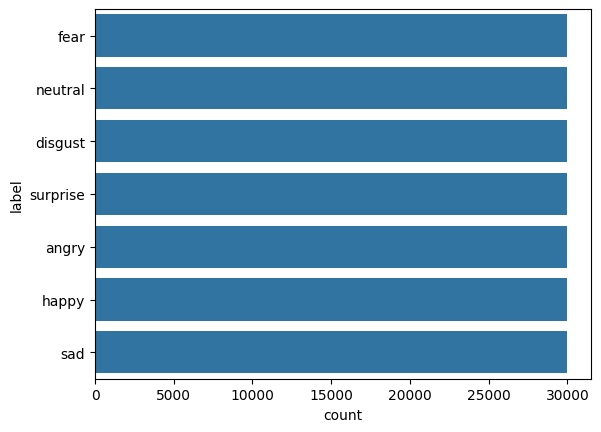

In [264]:
sns.countplot(train['label'])

## Grid of dataset images

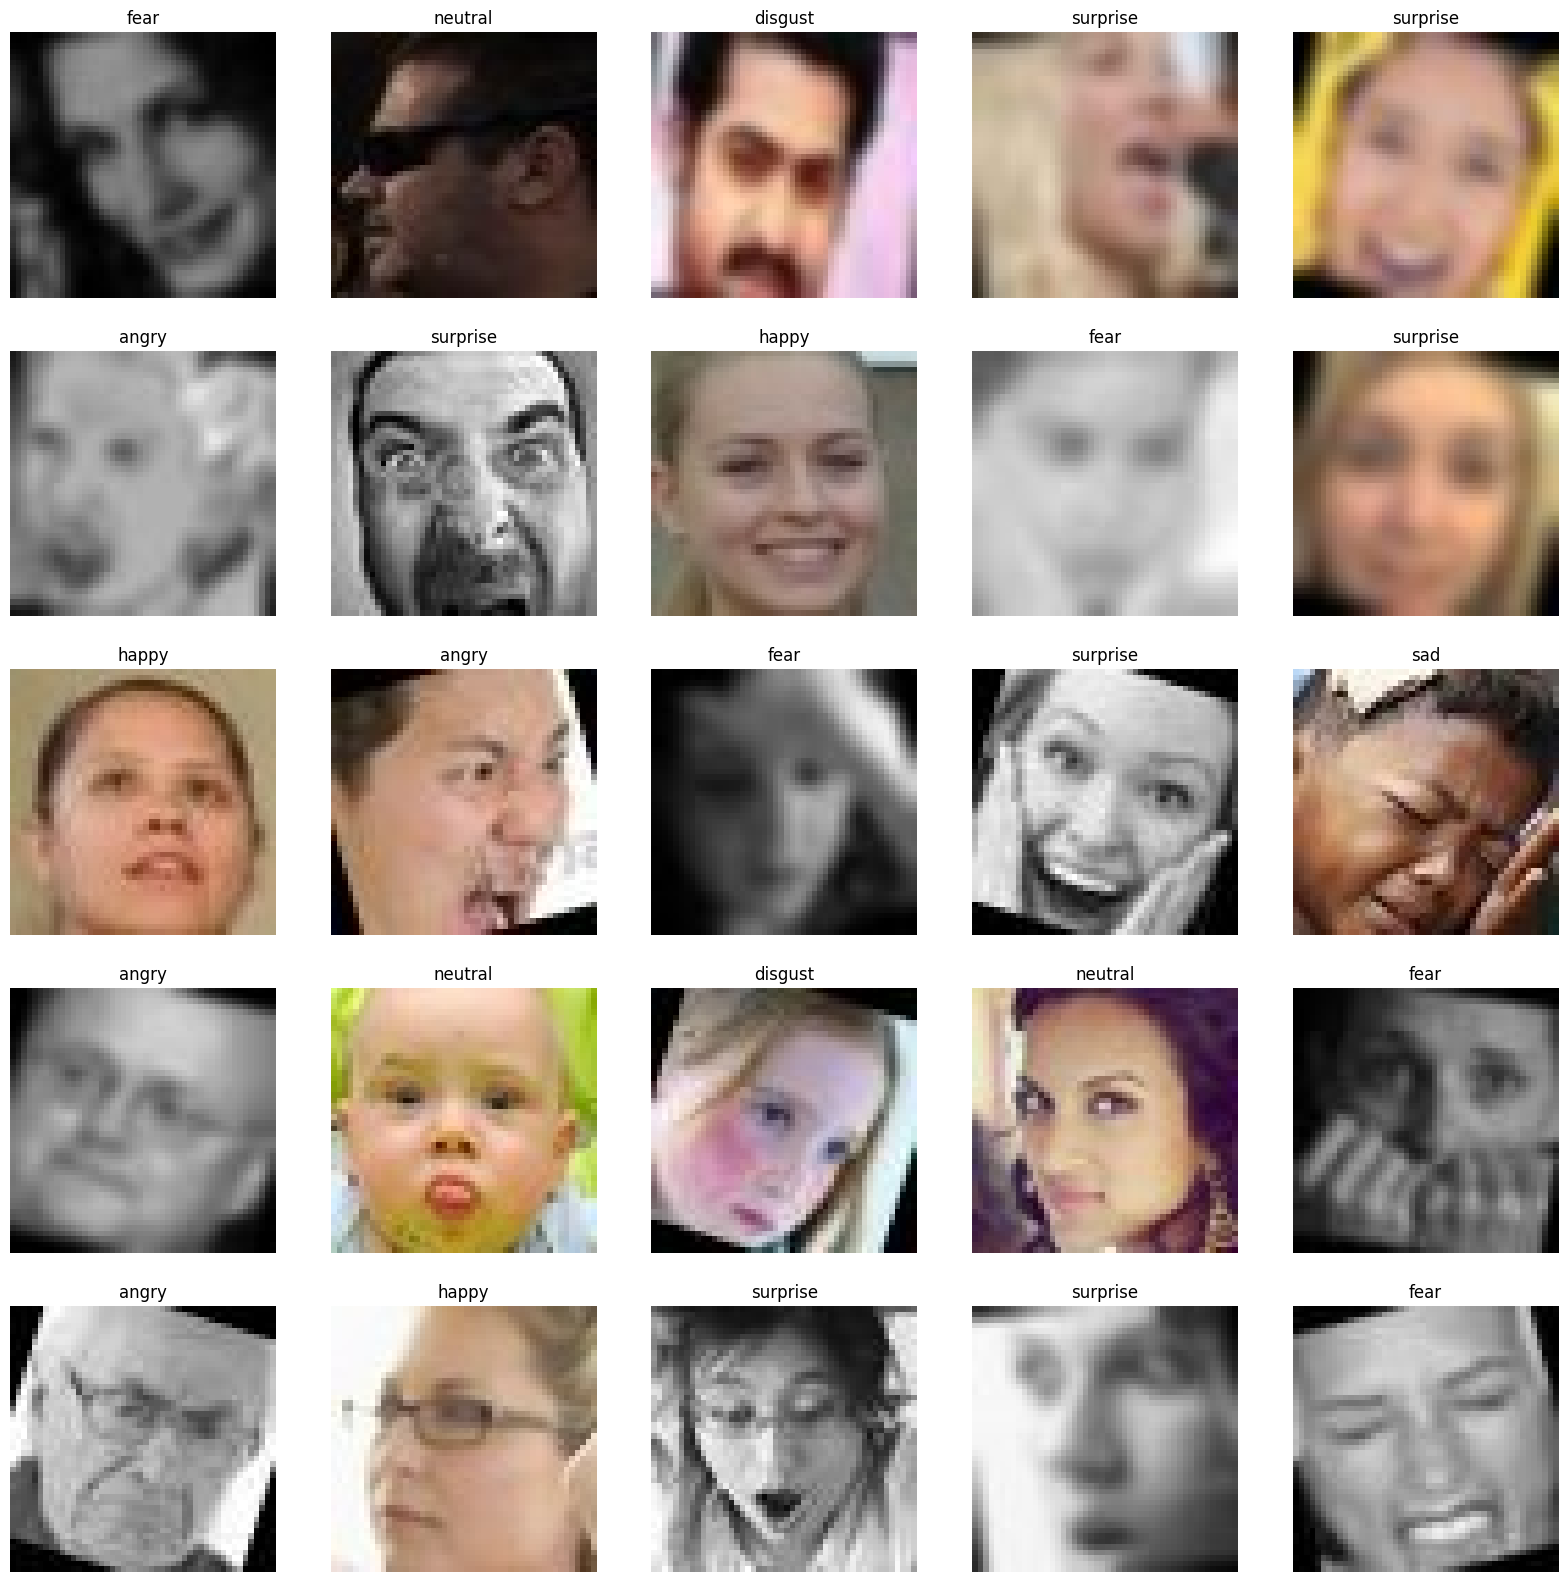

In [265]:
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, image_path, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(image_path)
    img = np.array(img)
    
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [266]:
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale')
        img = np.array(img)
        
        if DATASET.startswith('affectnet'): # affectnet images are 96x96
            img = img[::2, ::2] # so downsampling to 48x48 is required
        
        features.append(img)
    
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    
    return features

In [267]:
train_features = extract_features(train['image'])
x_train = train_features / 255.0

  0%|          | 0/210000 [00:00<?, ?it/s]

In [268]:
test_features = extract_features(test['image'])
x_test = test_features / 255.0

  0%|          | 0/30800 [00:00<?, ?it/s]

In [269]:
valid_features = extract_features(valid['image'])
x_valid = valid_features / 255.0

  0%|          | 0/63000 [00:00<?, ?it/s]

In [270]:
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [271]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)

y_train = le.transform(train['label'])
y_train = to_categorical(y_train, num_classes=len(labels))

y_test = le.transform(test['label'])
y_test = to_categorical(y_test, num_classes=len(labels))

y_valid = le.transform(valid['label'])
y_valid = to_categorical(y_valid, num_classes=len(labels))

In [272]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.])

In [273]:
input_shape = (48, 48, 1)
output_class = len(labels)

## Model Creation

In [274]:
# 5 layer model
model = Sequential(name='5-layer')

# convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# fatten layer
model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# output layer
model.add(Dense(output_class, activation='softmax'))

# _______________________________________________________

# # 6 layer model
# model = Sequential(name='6-layer')

# # Convolutional layers
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(2048, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# # global average pooling layer
# model.add(GlobalAveragePooling2D())

# # fully connected layers
# model.add(Dense(output_class, activation='softmax'))

In [275]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "5-layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 6, 6, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 6, 6, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 3, 3, 1024)          │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 3, 3, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 1, 1, 1024)          │              

 Total params: 16,307,207 (62.21 MB)

 Trainable params: 16,299,783 (62.18 MB)

 Non-trainable params: 7,424 (29.00 KB)

## Train the model

In [276]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/100
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 2636s 401ms/step - accuracy: 0.3002 - loss: 1.8606 - val_accuracy: 0.4335 - val_loss: 1.4781
Epoch 2/100
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 2565s 391ms/step - accuracy: 0.4773 - loss: 1.3711 - val_accuracy: 0.5038 - val_loss: 1.3066
Epoch 3/100
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 2626s 400ms/step - accuracy: 0.5321 - loss: 1.2495 - val_accuracy: 0.5205 - val_loss: 1.2816
Epoch 4/100
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 2600s 396ms/step - accuracy: 0.5780 - loss: 1.1422 - val_accuracy: 0.5353 - val_loss: 1.2489
Epoch 5/100
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 2560s 390ms/step - accuracy: 0.6232 - loss: 1.0314 - val_accuracy: 0.5432 - val_loss: 1.2549
Epoch 6/100
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 2560s 390ms/step - accuracy: 0.6684 - loss: 0.9171 - val_accuracy: 0.5452 - val_loss: 1.2819
Epoch 7/100
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 2667s 406ms/step - accuracy: 0.7063 - loss: 0.8256 - val_accuracy: 0.5421 - val_loss: 1.3493
Epoch 8/100
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 2609s

## Save the model

In [277]:
model.save(f'models/{model.name}_{DATASET}.keras')

## Plot the Results

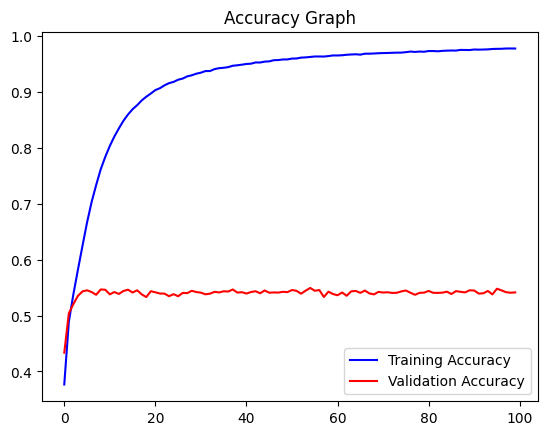

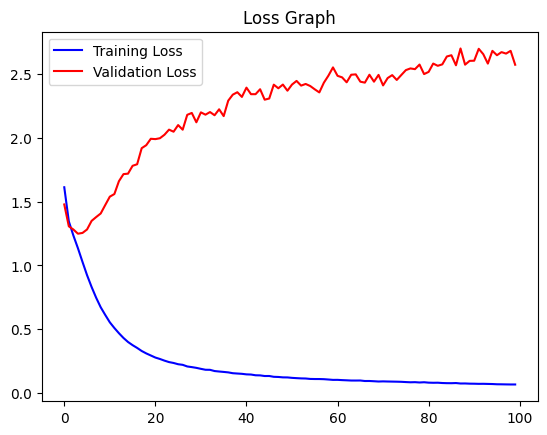

In [278]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Accuracy, F1, Precision, Recall

In [279]:
from tensorflow.keras.models import load_model

# model = load_model('models/model.keras')

# Przewidywanie klas na zestawie testowym
y_pred_prob = model.predict(x_test)

963/963 ━━━━━━━━━━━━━━━━━━━━ 78s 81ms/step


In [280]:
y_pred = np.array([np.eye(len(row))[row.argmax()] for row in y_pred_prob])

In [281]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

       angry       0.50      0.50      0.50      4400
     disgust       0.53      0.38      0.45      4400
        fear       0.58      0.45      0.50      4400
       happy       0.69      0.80      0.74      4400
     neutral       0.57      0.68      0.62      4400
         sad       0.40      0.44      0.42      4400
    surprise       0.58      0.61      0.60      4400

   micro avg       0.55      0.55      0.55     30800
   macro avg       0.55      0.55      0.55     30800
weighted avg       0.55      0.55      0.55     30800
 samples avg       0.55      0.55      0.55     30800



In [282]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(acc)

0.5523051948051948


## Confusion matrix

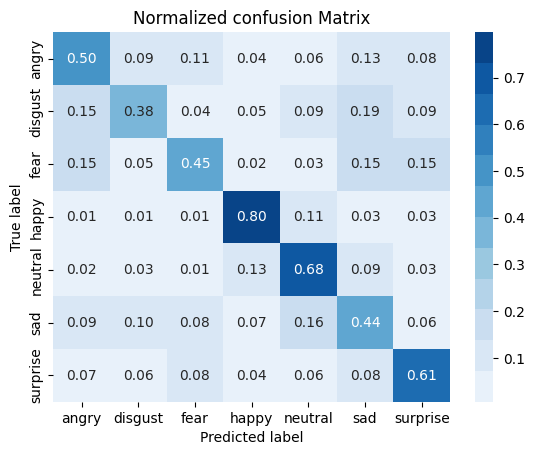

In [283]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(
    le.inverse_transform(np.argmax(y_test, axis=1)),
    le.inverse_transform(np.argmax(y_pred, axis=1)),
    normalize='true'
)

sns.heatmap(
    cm,
    annot=True,
    xticklabels=labels,
    yticklabels=labels,
    cmap=sns.color_palette('Blues', 12),
    fmt='.2f'
)
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Normalized confusion Matrix')
plt.show()

## Test with Image Data

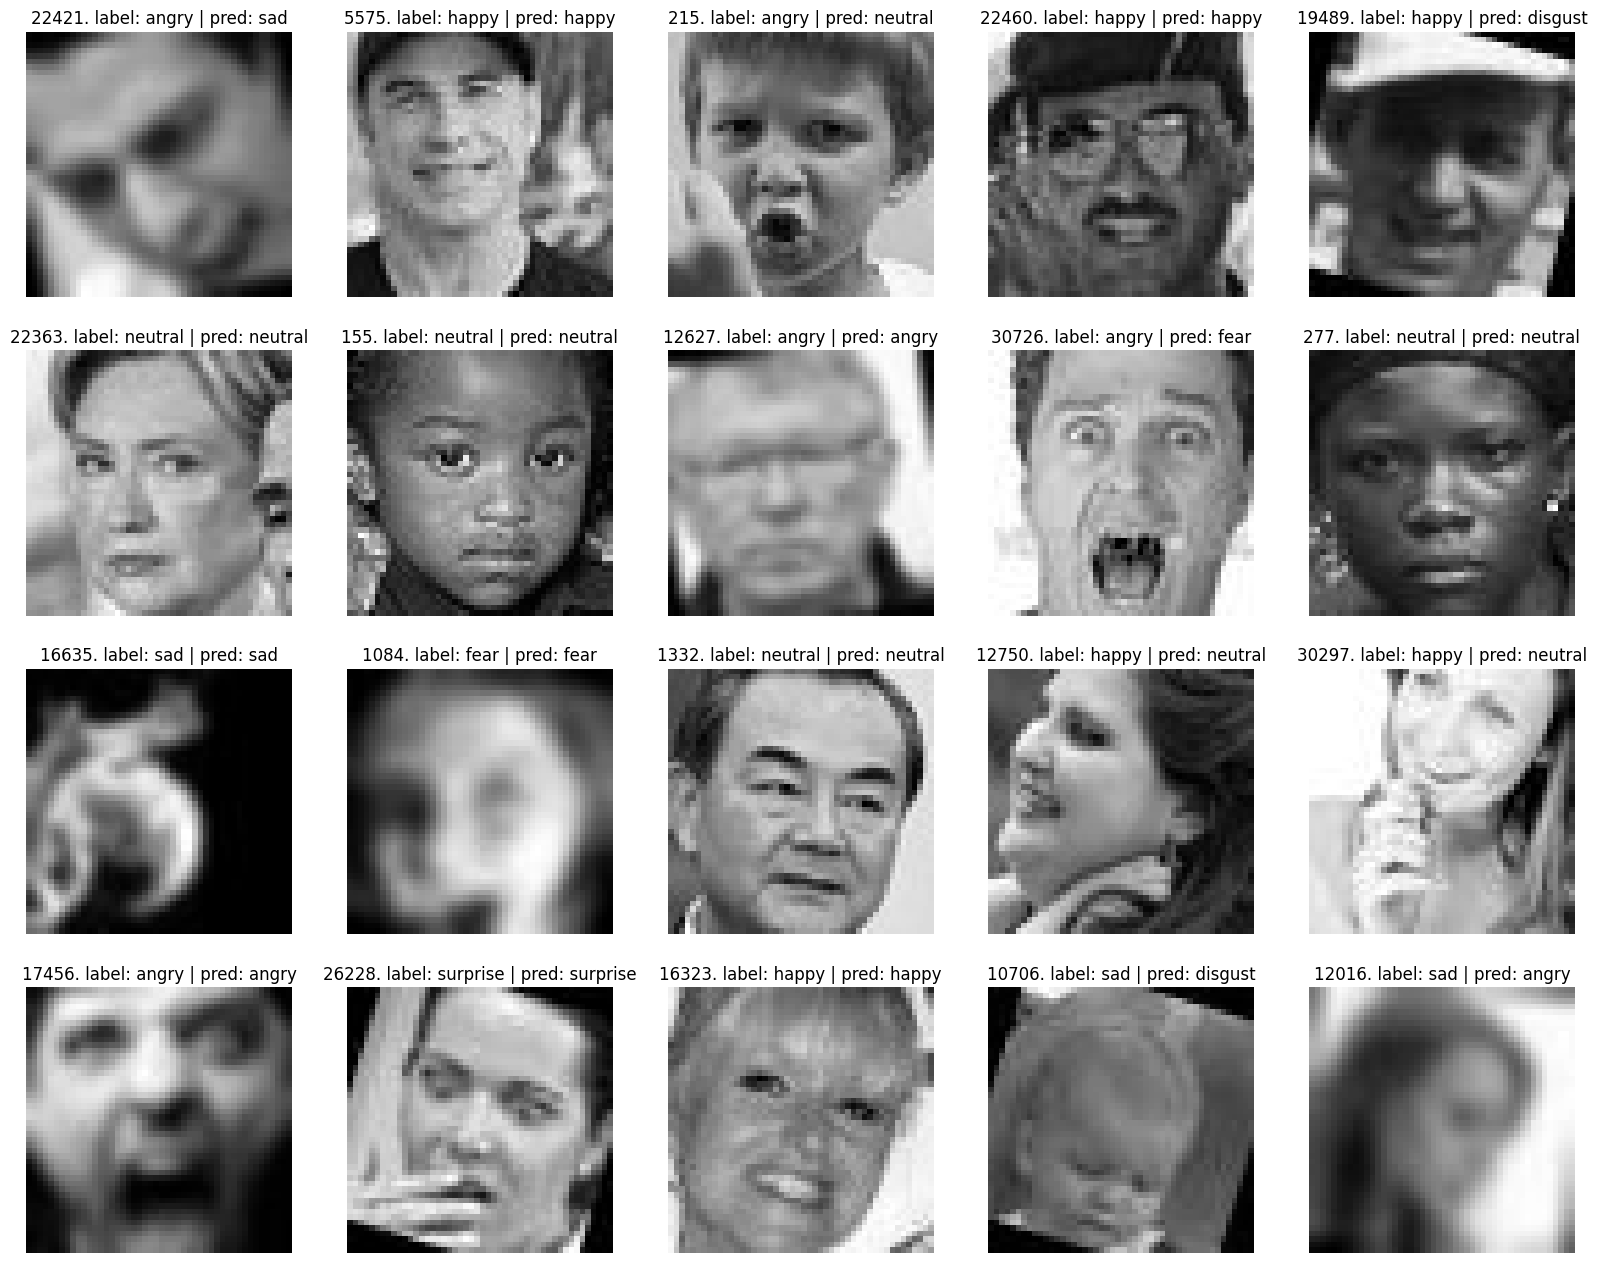

In [284]:
plt.figure(figsize=(20,20))

for i in range(20):
    plt.subplot(5, 5, i+1)

    img_index = random.randint(0, len(test))
    img = x_test[img_index]
    
    label = test['label'][img_index]

    pred = model.predict(img.reshape(1, 48, 48, 1), verbose=0)
    pred_label = le.inverse_transform([pred.argmax()])[0]
    
    plt.title(f"{img_index}. label: {label} | pred: {pred_label}")
    plt.imshow(img.reshape(48, 48), cmap='gray')
    plt.axis('off')